This notebook demonstrates how to use some of the classes and functions in RomPy's `fits` module. This module provides various functions and classes for performing univariate and multivariate fits and interpolating functions. Numerous examples are given here.

In [1]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set font size for plotting
font = {'size':14}
plt.rc('font', **font)

import rompy as rp

## Univariate fits

Univariate fits are for 1d data where an array of samples ($x$) and their corresponding data values (or responses, $y$) are interpolated to predict data at new samples.

Let's generate some 1d data that we'll use for our examples and serve as the "truth" for all our comparisons. The truth data can be found in the `_TruthData` class, which also includes the function (plotted below) that can be resampled to generate new data at new points.

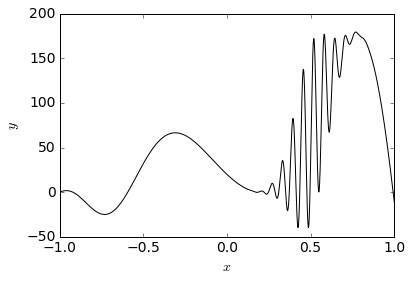

In [2]:
truth = rp._TruthData()

plt.plot(truth.x, truth.y, 'k-')
plt.xlabel('$x$')
plt.ylabel('$y$');

Generating a univariate spline interpolant of degree 5 that passes through all the data is easy to make.

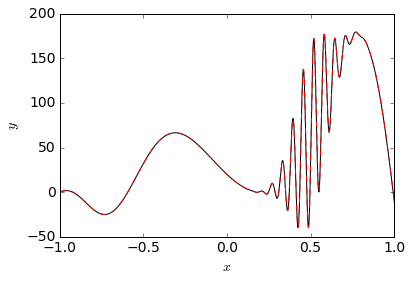

In [3]:
spline = rp.UnivariateFits(truth.x, truth.y, fit='spline', deg=5, s=0)

plt.plot(truth.x, truth.y, 'k-')
plt.plot(truth.x, spline(truth.x), 'r--')
plt.xlabel('$x$')
plt.ylabel('$y$');

The options used to build this interpolant, namely, the spline degree (5) and using a B-spline ($s=0$), are contained in the `options` attribute.

In [4]:
spline.options

{'deg': 5, 's': 0}

We can also attempt to fit a simple polynomial to the data by specifying the `polyfit` type and the degree.

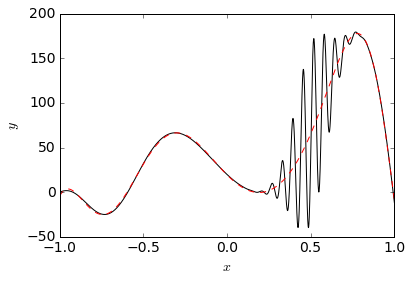

In [5]:
polyfit = rp.UnivariateFits(truth.x, truth.y, fit='polyfit', deg=10)

plt.plot(truth.x, truth.y, 'k-')
plt.plot(truth.x, polyfit(truth.x), 'r--')
plt.xlabel('$x$')
plt.ylabel('$y$');

We can also perform fits with Chebyshev (`chebfit`) or Legendre (`legfit`) polynomials.

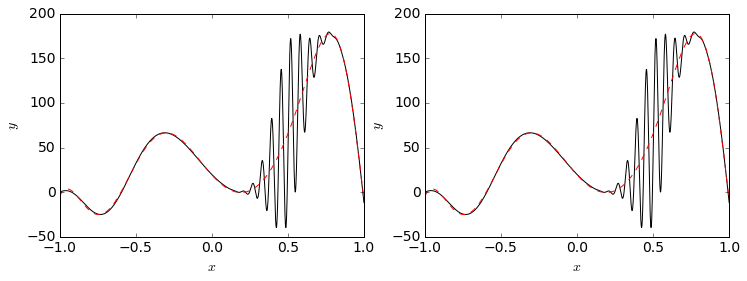

In [6]:
chebfit = rp.UnivariateFits(truth.x, truth.y, fit='chebfit', deg=10)
legfit = rp.UnivariateFits(truth.x, truth.y, fit='legfit', deg=10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,4])
ax[0].plot(truth.x, truth.y, 'k-')
ax[0].plot(truth.x, chebfit(truth.x), 'r--')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$');

ax[1].plot(truth.x, truth.y, 'k-')
ax[1].plot(truth.x, legfit(truth.x), 'r--')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$');

Evaluating the polyfit, chebfit, and legfit fits take different amounts of time, which may be relevant for multiple-query applications, even though they give nearly the same results.

In [7]:
%timeit -n100 -r3 polyfit(truth.x)
%timeit -n100 -r3 chebfit(truth.x)
%timeit -n100 -r3 legfit(truth.x)

100 loops, best of 3: 87.7 µs per loop
100 loops, best of 3: 134 µs per loop
100 loops, best of 3: 275 µs per loop


Another type of fit we can perform is from the products of linear combinations of sines and cosines. Select the `fourier` fit type and specify the "degree" (i.e., max wave number) to be used in the fits. Here's an example where the degree is relatively low ("IR" for "infrared") and high ("UV" for "ultraviolet"), respectively.

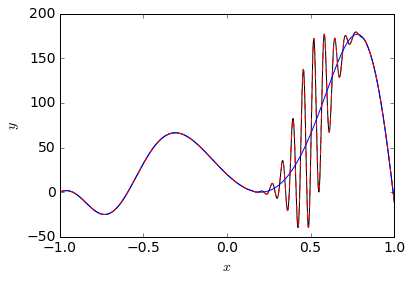

In [8]:
fourier_ir = rp.UnivariateFits(truth.x, truth.y, fit='fourier', deg=10)  # Low frequency fit
fourier_uv = rp.UnivariateFits(truth.x, truth.y, fit='fourier', deg=100) # High frequency fit

plt.plot(truth.x, truth.y, 'k-')
plt.plot(truth.x, fourier_ir(truth.x), 'b-')
plt.plot(truth.x, fourier_uv(truth.x), 'r--')
plt.xlabel('$x$')
plt.ylabel('$y$');

Instead of performing global fits to functions, we can perform a more piecewise fit using local regression techniques. In local regression, we fit the data with a polynomial of some requested degree over some window. A weighting factor can also be input to give less influence to the fit from points that are further away from the evaluation point. The default window size is the degree of the polynomial plus one. Here's an example that fits a quadratic over a window of size 10 elements.

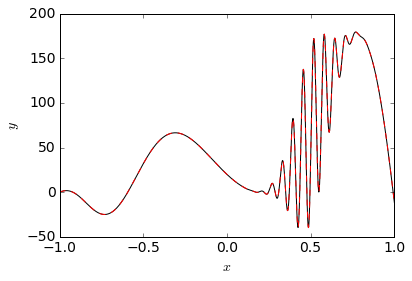

In [9]:
localreg = rp.UnivariateFits(truth.x, truth.y, fit='localreg', deg=2, window=10)

plt.plot(truth.x, truth.y, 'k-')
plt.plot(truth.x, localreg(truth.x), 'r--')
plt.xlabel('$x$')
plt.ylabel('$y$');

In [ ]:
# curve_fit

In [ ]:
# ODR

How reliable are any of the above fits for predicting or interpolating values at new samples? We can get a handle on the uncertainty of interpolation by performing cross-validation studies. The basic idea is to partition the data into $K$ subsets. Typically, $K=5$ or $10$ (default) is used. The data is rearranged randomly into these $K$ subsets such that their union is the original data and all subsets are non-intersecting. $K-1$ subsets are used to "train" the interpolant and the last subset is used to "test" the resulting interpolant. The largest absolute deviation on that test subset is recorded and the process is repeated until each of the $K$ subsets have been used for testing. This produces $K$ (correlated) errors measuring the largest deviation, one for each subset.

We can perform this study on, say, the `fourier_uv` interpolant by implementing the `CrossValidation.Kfold` method.

In [10]:
fourier_uv.CrossValidation.Kfold(truth.x, truth.y, K=10, parallel=False)

Here's a plot showing the largest interpolation errors on each of the $K=10$ subsets from this study.

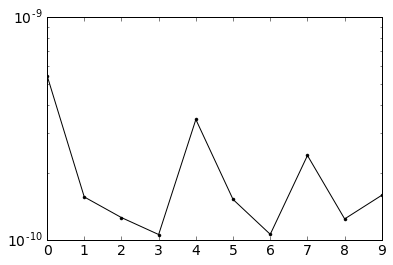

In [11]:
plt.semilogy(fourier_uv.CrossValidation.errors[10], 'k.-');

...and the mean of these largest errors is:

In [12]:
mean_error = np.mean(fourier_uv.CrossValidation.errors[10])
print mean_error

2.05611128123e-10


The `errors` attribute is a dictionary with keys given by the values of $K$ used for the cross-validation study that produced those errors. So performing a study with $K=5$ produces another entry.

In [13]:
# 5-fold cross-validation
fourier_uv.CrossValidation.Kfold(truth.x, truth.y, K=5, parallel=False)

# Print the `errors` dictionary
fourier_uv.CrossValidation.errors

{5: array([  1.62509117e-10,   1.66863856e-10,   1.53352886e-10,
          4.34491554e-10,   9.31855482e-10]),
 10: array([  5.44563505e-10,   1.55608859e-10,   1.25761179e-10,
          1.05587539e-10,   3.46000562e-10,   1.51623381e-10,
          1.05823128e-10,   2.38649989e-10,   1.24058097e-10,
          1.58435043e-10])}

Let's see how this average error depends on the degree of the fit. We know for low degrees that the `fourier` fit is poor in the high-frequency regime of the data. We can change the degree without creating a new instance of the `UnivariateFits` class by using the `update` method as shown below.

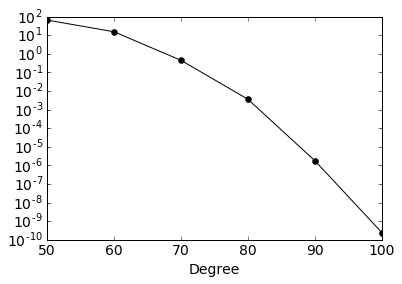

In [14]:
errors = []
degs = range(50, 110, 10)
for ii in degs:
    fourier_uv.update(deg=ii)
    fourier_uv.CrossValidation.Kfold(truth.x, truth.y, parallel=False)
    errors.append( np.mean(fourier_uv.CrossValidation.errors[10]) )

plt.semilogy(degs, errors, 'ko-')
plt.xlabel('Degree');

We can get a better estimate of such errors if we repeat the $K$-fold cross-validation study with a new realization of the data randomly distributed into the $K$ subsets. In fact, we may do this many times to generate an ensemble of the largest interpolation errors on the testing subsets. To do this, we use the `CrossValidation.Kfold_ensemble` method. (Note: Running the Kfold_ensemble method may take a couple of minutes.)

In [15]:
# Make sure deg equals 100
fourier_uv.update(deg=100)

# Note: There currently is a problem with setting parallel=True...
fourier_uv.CrossValidation.Kfold_ensemble(truth.x, truth.y, n=100, K=10, parallel=False) 

And let's plot the distribution of ensemble mean errors on a histogram.

Mean of ensemble means = 2.61575923991e-10


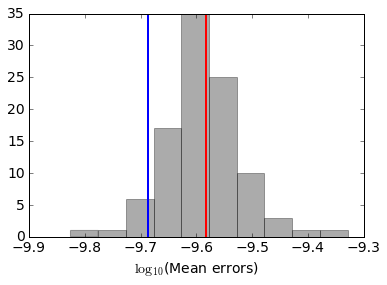

In [16]:
ensemble_errors = fourier_uv.CrossValidation.ensemble_errors[10]
mean_ensemble_errors = map(np.mean, ensemble_errors)

plt.hist(np.log10(mean_ensemble_errors), 10, color='k', alpha=0.33)  # Ensemble means

plt.axvline(np.log10(mean_error), 0, 1, linewidth=2);  # Mean from one K-fold cross-validation study
plt.axvline(np.log10(np.mean(mean_ensemble_errors)), 0, 1, color='r', linewidth=2);  # Mean of ensemble means
plt.xlabel('$\\log_{10}$(Mean errors)');

print "Mean of ensemble means =", np.mean(mean_ensemble_errors)

So in this example, we can expect the `fourier_uv` interpolant to be able to predict new values with an error less than about $2.6 \times 10^{-10}$ (or whatever value you find in the mean of ensemble means above). Since the truth data is generated by a known function then we can easily check this by directly evaluating the `fourier_uv` interpolant at new data samples.

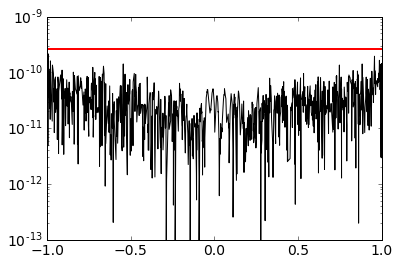

In [17]:
x_new = np.sort( (truth.x.max()-truth.x.min())*np.random.random(1000) - truth.x.max() )
y_new = truth.f(x_new)

plt.semilogy(x_new, np.abs(y_new-fourier_uv(x_new)), 'k-')
plt.axhline(np.mean(mean_ensemble_errors), 0, 1, color='r', linewidth=2);
plt.ylim(1e-13, 1e-9);

In fact, this error estimate depends on the number of partitions (or folds) $K$ used in the study and you can determine how so by computing the mean of the ensemble mean errors for different $K$'s.

## Multivariate fits

Multivariate fits are for 2d and higher dimensional data where an array of arrays of samples ($x$) -- one array for each dimension -- and their corresponding data values (or responses, $y$) are interpolated to predict data at new samples.

Let's generate some 2d test data that we'll use for a couple examples. This test data consists of 100 randomly generated samples in the $(x_1, x_2)$ plane and the "truth" data is given by the `truth_2d` function.

In [2]:
num = 10**2
x1 = 2.*np.random.random(num)-1.
x2 = 2.*np.random.random(num)-1.

def truth_2d(x):
    x1, x2 = x
    return np.sin(x1)*np.cos(4.*x2) + x2**3

y = truth_2d([x1, x2])

We use the `polyfit2d` method to perform a least squares fit using a polynomial in $x_1$ and $x_2$ that is fifteenth degree.

In [3]:
polyfit2d = rp.MultivariateFits([x1, x2], y, fit='polyfit2d', deg=15)

LinAlgError: 0-dimensional array given. Array must be two-dimensional

We plot the original data used in the fit as colored circles and the interpolated values as a color map.

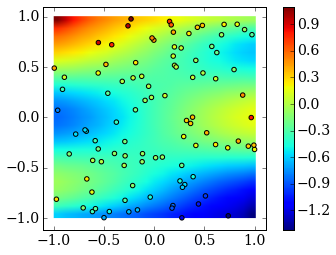

In [23]:
xx1, xx2 = np.meshgrid(np.linspace(-1., 1., 25), np.linspace(1., -1., 25))

yy = np.array([polyfit2d([xx1[ii], xx2[ii]]) for ii in range(len(xx1))])

plt.imshow(yy, extent=(-1., 1., -1., 1.))
plt.scatter(x1, x2, c=y)
plt.colorbar();

Below is a plot of the interpolation error of the fitting function at new points not used in building the fit. The second plot is a histogram showing the distribution of the absolute deviations on a log-10 scale.

Max error = 0.682109428869
Mean error = 0.00327051789148
Median error = 3.24181604496e-05


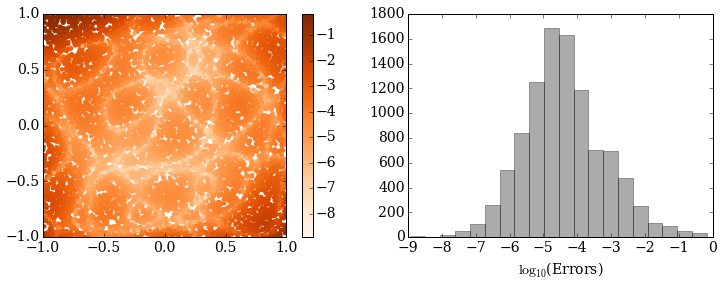

In [29]:
num = 100**2
x1_test = 2.*np.random.random(num)-1.
x2_test = 2.*np.random.random(num)-1.

errors = np.abs(truth_2d([x1_test, x2_test])-polyfit2d([x1_test, x2_test]))
print "Max error =", np.max(errors)
print "Mean error =", np.mean(errors)
print "Median error =", np.median(errors)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,4])
im = ax[0].scatter(x1_test, x2_test, c=np.log10(errors), edgecolor='None', cmap=plt.cm.Oranges)
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
plt.colorbar(im, ax=ax[0])

ax[1].hist(np.log10(errors), 20, color='k', alpha=0.33)
ax[1].set_xlabel('$\\log_{10}$(Errors)');

As with the univariate case, we can also perform K-fold cross-validation studies as described above. Here, we perform an ensemble of such studies for $K=10$.

In [26]:
polyfit2d.CrossValidation.Kfold_ensemble([x1, x2], y, n=100)

Mean of ensemble means = 0.0319406639176


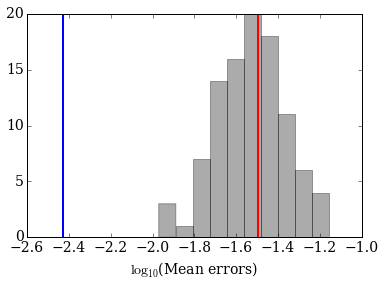

In [27]:
ensemble_errors = polyfit2d.CrossValidation.ensemble_errors[10]
mean_ensemble_errors = map(np.mean, ensemble_errors)

plt.hist(np.log10(mean_ensemble_errors), 10, color='k', alpha=0.33)  # Ensemble means

plt.axvline(np.log10(np.mean(errors)), 0, 1, linewidth=2);  # Mean from one K-fold cross-validation study
plt.axvline(np.log10(np.mean(mean_ensemble_errors)), 0, 1, color='r', linewidth=2);  # Mean of ensemble means
plt.xlabel('$\\log_{10}$(Mean errors)');

print "Mean of ensemble means =", np.mean(mean_ensemble_errors)

So, we might trust this particular fit to the data with an accuracy on predicting new values of about $0.032$, though it seems to be a conservative estimate here.

Let's do the same but fitting to 3d data. First, generate some test data.

In [16]:
num = 10**3
x1 = 2.*np.random.random(num)-1.
x2 = 2.*np.random.random(num)-1.
x3 = 2.*np.random.random(num)-1.

def truth_3d(x):
    x1, x2, x3 = x
    return ( np.sin(x1+x3)*np.cos(4.*x2) + x2**3 ) * np.exp(-(x1**2+x3)) 

y = truth_3d([x1, x2, x3])

Next, perform a least squares fit on the 3d data using a 15th degree polynomial.

In [17]:
polyfit3d = rp.MultivariateFits([x1, x2, x3], y, fit='polyfit3d', deg=15)

We show the interpolation errors on a new set of randomly selected points.

Max error = 0.0508471547978
Mean error = 0.000105258720443
Median error = 5.5579248064e-06


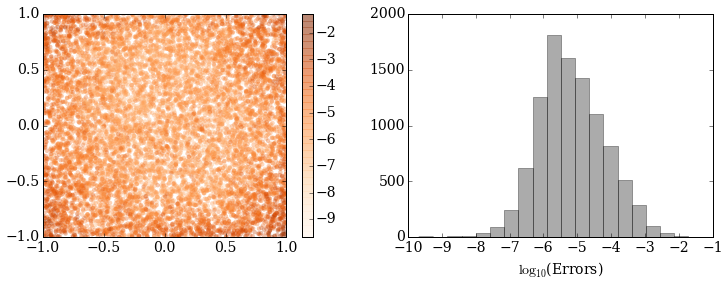

In [19]:
num = 100**2
x1_test = 2.*np.random.random(num)-1.
x2_test = 2.*np.random.random(num)-1.
x3_test = 2.*np.random.random(num)-1.

errors = np.abs(truth_3d([x1_test, x2_test, x3_test])-polyfit3d([x1_test, x2_test, x3_test]))
print "Max error =", np.max(errors)
print "Mean error =", np.mean(errors)
print "Median error =", np.median(errors)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,4])
im = ax[0].scatter(x1_test, x2_test, c=np.log10(errors), edgecolor='None', cmap=plt.cm.Oranges, alpha=0.33)
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
plt.colorbar(im, ax=ax[0])

ax[1].hist(np.log10(errors), 20, color='k', alpha=0.33)
ax[1].set_xlabel('$\\log_{10}$(Errors)');

The fit type `polyfitnd` builds a polynomial interpolant in $n$ dimensions with a specified degree. The usage is as shown for `polyfit3d` and one has access to the same cross-validation studies shown for the `polyfit2d` case.